# Unit 8: Proximal Policy Gradient (PPO) with PyTorch 🤖

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit9/thumbnail.png" alt="Unit 8"/>


In this notebook, you'll learn to **code your PPO agent from scratch with PyTorch using CleanRL implementation as model**.

To test its robustness, we're going to train it in:

- [LunarLander-v2 🚀](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)


⬇️ Here is an example of what you will achieve. ⬇️

In [1]:
%%html
<video controls autoplay><source src="https://huggingface.co/sb3/ppo-LunarLander-v2/resolve/main/replay.mp4" type="video/mp4"></video>

We're constantly trying to improve our tutorials, so **if you find some issues in this notebook**, please [open an issue on the GitHub Repo](https://github.com/huggingface/deep-rl-class/issues).

## Objectives of this notebook 🏆

At the end of the notebook, you will:

- Be able to **code your PPO agent from scratch using PyTorch**.
- Be able to **push your trained agent and the code to the Hub** with a nice video replay and an evaluation score 🔥.




## This notebook is from the Deep Reinforcement Learning Course
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/deep-rl-course-illustration.jpg" alt="Deep RL Course illustration"/>

In this free course, you will:

- 📖 Study Deep Reinforcement Learning in **theory and practice**.
- 🧑‍💻 Learn to **use famous Deep RL libraries** such as Stable Baselines3, RL Baselines3 Zoo, CleanRL and Sample Factory 2.0.
- 🤖 Train **agents in unique environments**

Don’t forget to **<a href="http://eepurl.com/ic5ZUD">sign up to the course</a>** (we are collecting your email to be able to **send you the links when each Unit is published and give you information about the challenges and updates).**


The best way to keep in touch is to join our discord server to exchange with the community and with us 👉🏻 https://discord.gg/ydHrjt3WP5

## Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 Study [PPO by reading Unit 8](https://huggingface.co/deep-rl-course/unit8/introduction) 🤗  

To validate this hands-on for the [certification process](https://huggingface.co/deep-rl-course/en/unit0/introduction#certification-process), you need to push one model, we don't ask for a minimal result but we **advise you to try different hyperparameters settings to get better results**.

If you don't find your model, **go to the bottom of the page and click on the refresh button**

For more information about the certification process, check this section 👉 https://huggingface.co/deep-rl-course/en/unit0/introduction#certification-process

## Set the GPU 💪
- To **accelerate the agent's training, we'll use a GPU**. To do that, go to `Runtime > Change Runtime type`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step1.jpg" alt="GPU Step 1">

- `Hardware Accelerator > GPU`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step2.jpg" alt="GPU Step 2">

# Create a virtual display 🔽

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames).

Hence the following cell will install the librairies and create and run a virtual screen 🖥

In [ ]:
!pip install setuptools==65.5.0

In [ ]:
!apt install python-opengl -y
!apt install ffmpeg
!apt install xvfb
!apt install swig cmake
!pip install pyglet==1.5
!pip3 install pyvirtualdisplay

In [5]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Install dependencies 🔽
For this exercise, we use `gym==0.22`.

In [ ]:
!pip install gym==0.22
!pip install imageio-ffmpeg
!pip install huggingface_hub
!pip install gym[box2d]==0.22

# Let's code Normal PPO from scratch with Costa Huang tutorial
- For the core implementation of PPO we're going to use the excellent [Costa Huang](https://costa.sh/) tutorial.
- In addition to the tutorial, to go deeper you can read the 37 core implementation details: https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/
- The full Code implementation of this blog: https://github.com/vwxyzjn/ppo-implementation-details
- Documentation of this implementation: https://docs.cleanrl.dev/rl-algorithms/ppo/
- For All Algorithms Single File Implementation: https://github.com/vwxyzjn/cleanrl

👉 The video tutorial: https://youtu.be/MEt6rrxH8W4

## Import 

In [20]:
%%writefile ppo.py
import argparse
import os
import random
import time
from distutils.util import strtobool

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

from huggingface_hub import HfApi, upload_folder
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import tempfile
import json
import shutil
import imageio

from wasabi import Printer
msg = Printer()

Overwriting ppo.py


## Argument Parser

In [21]:
%%writefile -a ppo.py

def parse_args():
    # fmt: off
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
        help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=1,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="cleanRL",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="whether to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="CartPole-v1",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=50000,
        help="total timesteps of the experiments")
    parser.add_argument("--learning-rate", type=float, default=2.5e-4,
        help="the learning rate of the optimizer")
    parser.add_argument("--num-envs", type=int, default=4,
        help="the number of parallel game environments")
    parser.add_argument("--num-steps", type=int, default=128,
        help="the number of steps to run in each environment per policy rollout")
    parser.add_argument("--anneal-lr", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggle learning rate annealing for policy and value networks")
    parser.add_argument("--gae", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Use GAE for advantage computation")
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--gae-lambda", type=float, default=0.95,
        help="the lambda for the general advantage estimation")
    parser.add_argument("--num-minibatches", type=int, default=4,
        help="the number of mini-batches")
    parser.add_argument("--update-epochs", type=int, default=4,
        help="the K epochs to update the policy")
    parser.add_argument("--norm-adv", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles advantages normalization")
    parser.add_argument("--clip-coef", type=float, default=0.2,
        help="the surrogate clipping coefficient")
    parser.add_argument("--clip-vloss", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles whether or not to use a clipped loss for the value function, as per the paper.")
    parser.add_argument("--ent-coef", type=float, default=0.01,
        help="coefficient of the entropy")
    parser.add_argument("--vf-coef", type=float, default=0.5,
        help="coefficient of the value function")
    parser.add_argument("--max-grad-norm", type=float, default=0.5,
        help="the maximum norm for the gradient clipping")
    parser.add_argument("--target-kl", type=float, default=0.015,
        help="the target KL divergence threshold")

    # Adding HuggingFace argument
    parser.add_argument("--repo-id", type=str, default="hishamcse/ppo-CartPole-v1-scratch", help="id of the model repository from the Hugging Face Hub {username/repo_name}")

    args = parser.parse_args()
    args.batch_size = int(args.num_envs * args.num_steps)
    args.minibatch_size = int(args.batch_size // args.num_minibatches)
    # fmt: on
    return args

Appending to ppo.py


## Make Environment 

Implements **vectorized architecture** of the environment

In [22]:
%%writefile -a ppo.py

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

Appending to ppo.py


## Agent Setup 

In [23]:
%%writefile -a ppo.py

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

Appending to ppo.py


In [24]:
%%writefile -a ppo.py

class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )
        
    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)

Appending to ppo.py


## Add the Hugging Face Integration 🤗
- In order to push our model to the Hub, we need to define a function `package_to_hub`
- Next, we add the methods needed to push the model to the Hub

- These methods will:
  - `_evalutate_agent()`: evaluate the agent.
  - `_generate_model_card()`: generate the model card of your agent.
  - `_record_video()`: record a video of your agent.

### Evaluate Agent 

In [25]:
%%writefile -a ppo.py

def _evaluate_agent(env, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    while done is False:
      state = torch.Tensor(state).to(device)
      action, _, _, _ = policy.get_action_and_value(state)
      new_state, reward, done, info = env.step(action.cpu().numpy())
        
      total_rewards_ep += reward
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

Appending to ppo.py


### Record Video 

In [26]:
%%writefile -a ppo.py

def record_video(env, policy, out_directory, fps=30):
  images = []
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    state = torch.Tensor(state).to(device)
    # Take the action (index) that have the maximum expected future reward given that state
    action, _, _, _  = policy.get_action_and_value(state)
    state, reward, done, info = env.step(action.cpu().numpy()) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

Appending to ppo.py


### Generate Model Card & Metadata 

In [27]:
%%writefile -a ppo.py

def _generate_model_card(model_name, env_id, mean_reward, std_reward, hyperparameters):
  """
  Generate the model card for the Hub
  :param model_name: name of the model
  :env_id: name of the environment
  :mean_reward: mean reward of the agent
  :std_reward: standard deviation of the mean reward of the agent
  :hyperparameters: training arguments
  """
  # Step 1: Select the tags
  metadata = generate_metadata(model_name, env_id, mean_reward, std_reward)

  # Transform the hyperparams namespace to string
  converted_dict = vars(hyperparameters)
  converted_str = str(converted_dict)
  converted_str = converted_str.split(", ")
  converted_str = '\n'.join(converted_str)

  # Step 2: Generate the model card
  model_card = f"""
  # PPO Agent Implemented from scratch Playing {env_id}

  This is a trained model of a PPO agent playing {env_id}.

  # Hyperparameters
  ```python
  {converted_str}
  ```
  """
  return model_card, metadata


def generate_metadata(model_name, env_id, mean_reward, std_reward):
  """
  Define the tags for the model card
  :param model_name: name of the model
  :param env_id: name of the environment
  :mean_reward: mean reward of the agent
  :std_reward: standard deviation of the mean reward of the agent
  """
  metadata = {}
  metadata["tags"] = [
        env_id,
        "ppo",
        "deep-reinforcement-learning",
        "reinforcement-learning",
        "scratch-implementation",
        "deep-rl-course"
  ]

  # Add metrics
  eval = metadata_eval_result(
      model_pretty_name=model_name,
      task_pretty_name="reinforcement-learning",
      task_id="reinforcement-learning",
      metrics_pretty_name="mean_reward",
      metrics_id="mean_reward",
      metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
      dataset_pretty_name=env_id,
      dataset_id=env_id,
  )

  # Merges both dictionaries
  metadata = {**metadata, **eval}

  return metadata


def _save_model_card(local_path, generated_model_card, metadata):
    """Saves a model card for the repository.
    :param local_path: repository directory
    :param generated_model_card: model card generated by _generate_model_card()
    :param metadata: metadata
    """
    readme_path = local_path / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = generated_model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)


def _add_logdir(local_path: Path, logdir: Path):
  """Adds a logdir to the repository.
  :param local_path: repository directory
  :param logdir: logdir directory
  """
  if logdir.exists() and logdir.is_dir():
    # Add the logdir to the repository under new dir called logs
    repo_logdir = local_path / "logs"

    # Delete current logs if they exist
    if repo_logdir.exists():
      shutil.rmtree(repo_logdir)

    # Copy logdir into repo logdir
    shutil.copytree(logdir, repo_logdir)

Appending to ppo.py


### Push to hub 

In [28]:
%%writefile -a ppo.py

def package_to_hub(repo_id,
                model,
                hyperparameters,
                eval_env,
                video_fps=30,
                commit_message="Push agent to the Hub",
                token= None,
                logs=None
                ):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the hub
  :param repo_id: id of the model repository from the Hugging Face Hub
  :param model: trained model
  :param eval_env: environment used to evaluate the agent
  :param fps: number of fps for rendering the video
  :param commit_message: commit message
  :param logs: directory on local machine of tensorboard logs you'd like to upload
  """
  msg.info(
        "This function will save, evaluate, generate a video of your agent, "
        "create a model card and push everything to the hub. "
        "It might take up to 1min. \n "
        "This is a work in progress: if you encounter a bug, please open an issue."
    )
  # Step 1: Clone or create the repo
  repo_url = HfApi().create_repo(
        repo_id=repo_id,
        token=token,
        private=False,
        exist_ok=True,
    )

  with tempfile.TemporaryDirectory() as tmpdirname:
    tmpdirname = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model.state_dict(), tmpdirname / "model.pt")

    # Step 3: Evaluate the model and build JSON
    mean_reward, std_reward = _evaluate_agent(eval_env, 10, model)

    # First get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
        "env_id": hyperparameters.env_id,
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "n_evaluation_episodes": 10,
        "eval_datetime": eval_form_datetime,
    }

    # Write a JSON file
    with open(tmpdirname / "results.json", "w") as outfile:
      json.dump(evaluate_data, outfile)

    # Step 4: Generate a video
    video_path =  tmpdirname / "replay.mp4"
    record_video(eval_env, model, video_path, video_fps)

    # Step 5: Generate the model card
    generated_model_card, metadata = _generate_model_card("PPO", hyperparameters.env_id, mean_reward, std_reward, hyperparameters)
    _save_model_card(tmpdirname, generated_model_card, metadata)

    # Step 6: Add logs if needed
    if logs:
      _add_logdir(tmpdirname, Path(logs))

    msg.info(f"Pushing repo {repo_id} to the Hugging Face Hub")

    repo_url = upload_folder(
            repo_id=repo_id,
            folder_path=tmpdirname,
            path_in_repo="",
            commit_message=commit_message,
            token=token,
        )

    msg.info(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")
  return repo_url

Appending to ppo.py


## Main: Train, Evaluate & Publish 

### Clipped Value Loss Function

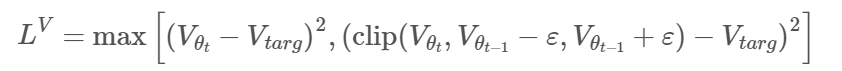

In [29]:
%%writefile -a ppo.py

if __name__ == "__main__":
    args = parse_args()
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
        
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )
    
    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    
    # env setup
    envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
    )
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    # agent setup
    agent = Agent(envs).to(device)
    
    # optimizer setup
    optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)
    
    # ALGO Logic: Storage setup
    obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
    rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
    dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
    values = torch.zeros((args.num_steps, args.num_envs)).to(device)

    # TRY NOT TO MODIFY: start the game
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(args.num_envs).to(device)
    num_updates = args.total_timesteps // args.batch_size
    
    for update in range(1, num_updates + 1):
        # Annealing the rate if instructed to do so.
        if args.anneal_lr:
            frac = 1.0 - (update - 1.0) / num_updates
            lrnow = frac * args.learning_rate
            optimizer.param_groups[0]["lr"] = lrnow

        for step in range(0, args.num_steps):
            global_step += 1 * args.num_envs
            obs[step] = next_obs
            dones[step] = next_done

            # ALGO LOGIC: action logic
            with torch.no_grad():
                action, logprob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()
            actions[step] = action
            logprobs[step] = logprob

            # TRY NOT TO MODIFY: execute the game and log data.
            next_obs, reward, done, info = envs.step(action.cpu().numpy())
            
            rewards[step] = torch.tensor(reward).to(device).view(-1)
            next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

            for item in info:
                if "episode" in item.keys():
                    print(f"global_step={global_step}, episodic_return={item['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", item["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", item["episode"]["l"], global_step)
                    break
                    
        # bootstrap value if not done
        with torch.no_grad():
            next_value = agent.get_value(next_obs).reshape(1, -1)
            if args.gae:
                advantages = torch.zeros_like(rewards).to(device)
                lastgaelam = 0
                for t in reversed(range(args.num_steps)):
                    if t == args.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        nextvalues = values[t + 1]
                    delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
                    advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + values
            else:
                returns = torch.zeros_like(rewards).to(device)
                for t in reversed(range(args.num_steps)):
                    if t == args.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        next_return = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + args.gamma * nextnonterminal * next_return
                advantages = returns - values

        # flatten the batch
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)

        # Optimizing the policy and value network
        b_inds = np.arange(args.batch_size)
        clipfracs = []
        for epoch in range(args.update_epochs):
            np.random.shuffle(b_inds)
            for start in range(0, args.batch_size, args.minibatch_size):
                end = start + args.minibatch_size
                mb_inds = b_inds[start:end]

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()
                
                # debug (approximate Kullback–Leibler divergence)
                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()     # new poposed in blog
                    # the fraction of the training data that triggered the clipped objective.
                    clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

                mb_advantages = b_advantages[mb_inds]
                if args.norm_adv:
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)
                    
                # Policy loss (Clipped Surrogate Objective Function)
                pg_loss1 = -mb_advantages * ratio     # the unclipper part
                pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)   # the clipped part
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()
                
                # Value loss (Clipped Value Loss Function)
                newvalue = newvalue.view(-1)
                if args.clip_vloss:
                    v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                    v_clipped = b_values[mb_inds] + torch.clamp(
                        newvalue - b_values[mb_inds],
                        -args.clip_coef,
                        args.clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()
                else:
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()
                    
                # Entropy loss
                entropy_loss = entropy.mean()
                loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef
                
                # Global gradient clipping
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
                optimizer.step()
            
            # Early Stopping(Kullback–Leibler divergence optimization)
            if args.target_kl is not None:
                if approx_kl > args.target_kl:
                    break
                    
        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
        writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
        writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
        writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
        writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
        writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
        writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
        writer.add_scalar("losses/explained_variance", explained_var, global_step)
        print("SPS:", int(global_step / (time.time() - start_time)))
        writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

    envs.close()
    writer.close()

    # Create the evaluation environment
    eval_env = gym.make(args.env_id)

    package_to_hub(repo_id = args.repo_id,
                model = agent, # The model we want to save
                hyperparameters = args,
                eval_env = gym.make(args.env_id),
                logs= f"runs/{run_name}",
                )

Appending to ppo.py


## HuggingFace Login

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/create-token.jpg" alt="Create HF Token">

- Copy the token
- Run the cell below and paste the token

In [18]:
from huggingface_hub import notebook_login
notebook_login()
!git config --global credential.helper store

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

## Let's start the training 🔥
- ⚠️ ⚠️ ⚠️  Don't use **the same repo id with the one you used for the Unit 1**
- Now that you've coded from scratch PPO and added the Hugging Face Integration, we're ready to start the training 🔥
- Now we just need to run this python script using `python <name-of-python-script>.py` with the additional parameters we defined with `argparse`

- You should modify more hyperparameters otherwise the training will not be super stable.

In [ ]:
!python ppo.py --env-id="LunarLander-v2" --repo-id="hishamcse/ppo-LunarLander-v2-scratch" --total-timesteps=100000

See you on Unit 8, part 2 where we going to train agents to play Doom 🔥
## Keep learning, stay awesome 🤗